<a href="https://colab.research.google.com/github/benfrancis314/mental-frontiers-pub/blob/master/Top_Model_LFP_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM-Based Neural Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# System
import os
import shutil
import time
import pickle

# Data science
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.image  as mpimg
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.random.set_seed(7) # Bc luck doesn't hurt
np.random.seed(7)


## Data 

In [11]:
drift_grat_file = open('./drive/My Drive/Colab Notebooks/drift_grat.pickle', 'rb')
drift_grat = pickle.load(drift_grat_file)
drift_grat_file.close()
df = drift_grat
df.head


<bound method NDFrame.head of                   LFP       Ch2       Ch3  ...      Ch84          Ch85      Ch86
time                                       ...                                  
5000.000243 -0.000090  0.000225  0.000223  ... -0.000050  1.170000e-06 -0.000003
5000.001043 -0.000137  0.000222  0.000215  ... -0.000062 -1.228500e-05 -0.000009
5000.001843 -0.000221  0.000234  0.000222  ... -0.000064 -2.008500e-05 -0.000019
5000.002643 -0.000306  0.000217  0.000239  ... -0.000052 -2.925000e-05 -0.000019
5000.003443 -0.000350  0.000211  0.000222  ... -0.000061 -3.783000e-05 -0.000023
...               ...       ...       ...  ...       ...           ...       ...
5349.996410  0.000012  0.000042  0.000038  ...  0.000000 -1.950000e-07 -0.000020
5349.997210 -0.000018  0.000056  0.000051  ... -0.000007  8.580000e-06 -0.000014
5349.998010 -0.000030  0.000022  0.000031  ...  0.000004  6.045000e-06 -0.000031
5349.998810 -0.000019  0.000044  0.000047  ... -0.000005 -4.875000e-06 -0.00002

#### Select Channels

In [17]:
channels_considered = ['Ch43', 'Ch44', 'Ch45', 'Ch46', 'Ch47', 'Ch48', 'Ch49', 'Ch50', 'Ch51', 'Ch52', 'Ch53', 'Ch54', 'Ch55', 'Ch56', 'Ch57', 'Ch58', 'Ch59'] 
channel_forecasted = 1     # As an index of channels
features = df[channels_considered]
middle_channel = 9

# features = df
features.shape
channels = features.shape[1]
features.head()

,Ch43,Ch44,Ch45,Ch46,Ch47,Ch48,Ch49,Ch50,Ch51,Ch52,Ch53,Ch54,Ch55,Ch56,Ch57,Ch58,Ch59
time,,,,,,,,,,,,,,,,,
5000.000243,0.000039,-0.000071,-0.000027,-0.000122,-0.000097,-0.000129,-0.000030,0.000004,-0.000090,-0.000084,-0.000167,-0.000179,-0.000197,-0.000247,-0.000290,-0.000302,-0.000321
5000.001043,-0.000002,-0.000134,-0.000116,-0.000189,-0.000183,-0.000203,-0.000065,-0.000096,-0.000137,-0.000154,-0.000191,-0.000238,-0.000239,-0.000383,-0.000392,-0.000300,-0.000296
5000.001843,-0.000023,-0.000171,-0.000152,-0.000242,-0.000271,-0.000256,-0.000165,-0.000234,-0.000221,-0.000235,-0.000217,-0.000286,-0.000309,-0.000482,-0.000381,-0.000333,-0.000298
5000.002643,-0.000043,-0.000197,-0.000183,-0.000278,-0.000330,-0.000287,-0.000268,-0.000370,-0.000306,-0.000305,-0.000254,-0.000323,-0.000363,-0.000515,-0.000412,-0.000388,-0.000343
5000.003443,-0.000084,-0.000211,-0.000210,-0.000300,-0.000352,-0.000334,-0.000324,-0.000432,-0.000350,-0.000339,-0.000284,-0.000356,-0.000380,-0.000550,-0.000418,-0.000364,-0.000364


#### Verify data is imported properly

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1760287710>,
      dtype=object)

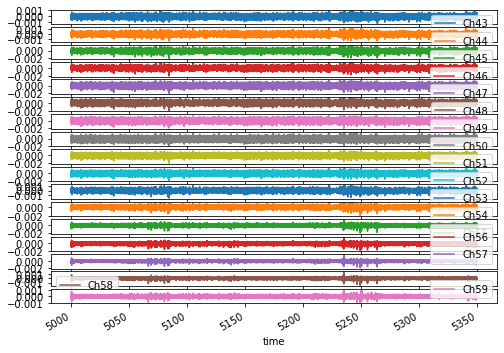

In [127]:
features.plot(subplots=True)  # To ensure data loaded properly

### LSTM Params

In [0]:
# Sec 1
TRAIN_SPLIT = 300000  # Training Split
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std  # Standardize again

# Sec 2
BATCH_SIZE = 512
BUFFER_SIZE = 10000

EVALUATION_INTERVAL = 200 #TRAIN_SPLT // BATCH_SIZE
EPOCHS = 150

### Data Prep


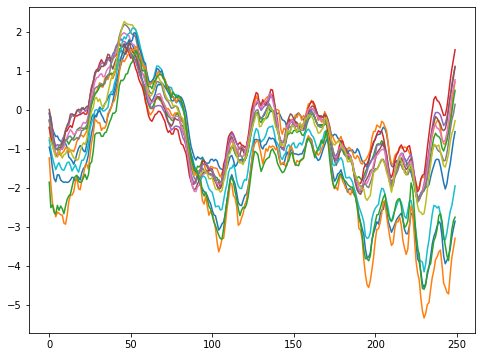

In [128]:
plt.plot(dataset[0:250,:])

In [0]:
# May take a moment
window_size = 90  # Past history to incorporate
forecast_length = 80  # Forecast length

x_train, y_train = format_data(dataset, dataset[:,middle_channel], 0, TRAIN_SPLIT, window_size,
                                                 forecast_length)
x_val, y_val = format_data(dataset, dataset[:,middle_channel], 0, TRAIN_SPLIT, window_size,
                                                 forecast_length)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE, drop_remainder = True).repeat()

## Model

In [0]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(1000, input_shape=x_train.shape[-2:]), # 
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1000,return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1000)),
    tf.keras.layers.Dense(forecast_length)
])



learning_rate = 0.01
decay = 0 # Learning rate decay
optimizer = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

lstm_model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=["mae", "mse"])

In [0]:
checkpoints_cb = keras.callbacks.ModelCheckpoint("lstm_drift_grat.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True)
lstm_history = lstm_model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50, callbacks=[checkpoints_cb, early_stopping_cb])

Epoch 1/150
200/200 [==============================] - 50s 249ms/step - loss: 0.2783 - mae: 0.6109 - mse: 0.6178 - val_loss: 0.2701 - val_mae: 0.6011 - val_mse: 0.5974
Epoch 2/150
200/200 [==============================] - 49s 246ms/step - loss: 0.2543 - mae: 0.5778 - mse: 0.5571 - val_loss: 0.2654 - val_mae: 0.5916 - val_mse: 0.5890
Epoch 3/150
200/200 [==============================] - 49s 243ms/step - loss: 0.2499 - mae: 0.5699 - mse: 0.5497 - val_loss: 0.2441 - val_mae: 0.5641 - val_mse: 0.5355
Epoch 4/150
200/200 [==============================] - 48s 238ms/step - loss: 0.2517 - mae: 0.5730 - mse: 0.5524 - val_loss: 0.2612 - val_mae: 0.5854 - val_mse: 0.5806
Epoch 5/150
200/200 [==============================] - 47s 237ms/step - loss: 0.2328 - mae: 0.5472 - mse: 0.5052 - val_loss: 0.2604 - val_mae: 0.5831 - val_mse: 0.5779
Epoch 6/150
200/200 [==============================] - 47s 237ms/step - loss: 0.2248 - mae: 0.5363 - mse: 0.4878 - val_loss: 0.2273 - val_mae: 0.5411 - val_mse:

In [118]:
mse_tot = 0
mae_tot = 0
samples = 50
for x, y in val_data.take(samples):
  results = lstm_model.predict(x)[0]
  mse_tot += keras.metrics.mean_squared_error(y[0], results).numpy()
  mae_tot += keras.metrics.mean_absolute_error(y[0], results).numpy()
  print(" MSE: ", keras.metrics.mean_squared_error(y[0], results).numpy())
  # print("MAE: ", keras.metrics.mean_absolute_error(y[0], results).numpy())

mse_avg = mse_tot/samples
mae_avg = mae_tot/samples
print("MSE Avg: ", mse_avg)
print("MAE Avg: ", mae_avg)

 MSE:  0.020294745
 MSE:  0.0108399615
 MSE:  0.018438581
 MSE:  0.005647121
 MSE:  0.009408109
 MSE:  0.0155093465
 MSE:  0.013380607
 MSE:  0.015843555
 MSE:  0.015067063
 MSE:  0.019693619
 MSE:  0.008766843
 MSE:  0.010924631
 MSE:  0.008671981
 MSE:  0.014848793
 MSE:  0.011234261
 MSE:  0.010071491
 MSE:  0.012125646
 MSE:  0.01772684
 MSE:  0.025766043
 MSE:  0.013682147
 MSE:  0.012940521
 MSE:  0.017618226
 MSE:  0.014423064
 MSE:  0.02510211
 MSE:  0.007950649
 MSE:  0.017914936
 MSE:  0.015573368
 MSE:  0.013419663
 MSE:  0.009834265
 MSE:  0.009611822
 MSE:  0.02299911
 MSE:  0.011577179
 MSE:  0.01450151
 MSE:  0.014362483
 MSE:  0.020901741
 MSE:  0.009303373
 MSE:  0.0107856905
 MSE:  0.0099335695
 MSE:  0.01147449
 MSE:  0.010225531
 MSE:  0.0071549993
 MSE:  0.017266447
 MSE:  0.027337303
 MSE:  0.0067812027
 MSE:  0.009516494
 MSE:  0.010129788
 MSE:  0.014846468
 MSE:  0.009422208
 MSE:  0.021499684
 MSE:  0.008108399
MSE Avg:  0.013809153586626053
MAE Avg:  0.092668

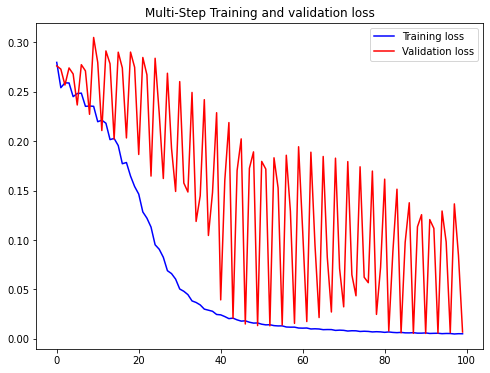

In [119]:
plot_train_history(lstm_history, 'Multi-Step Training and validation loss')

### Predict a Multi-Step Future

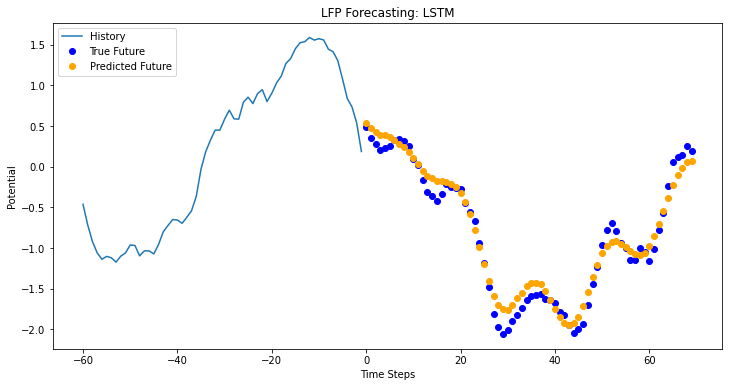

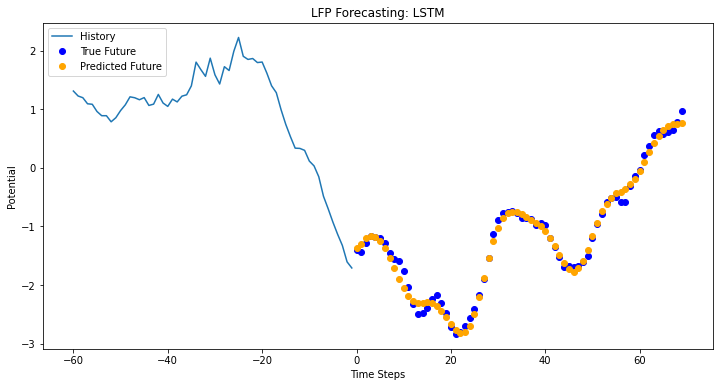

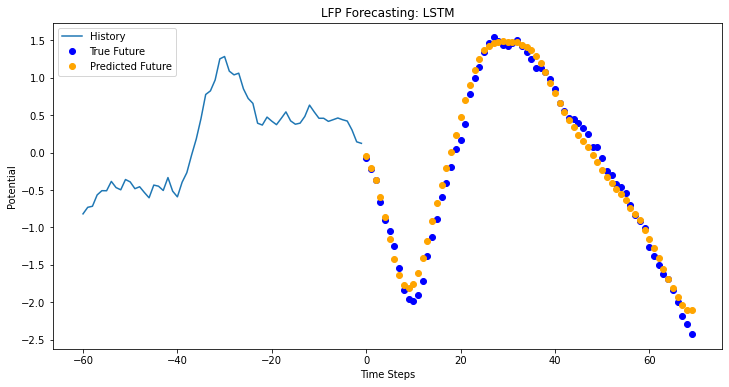

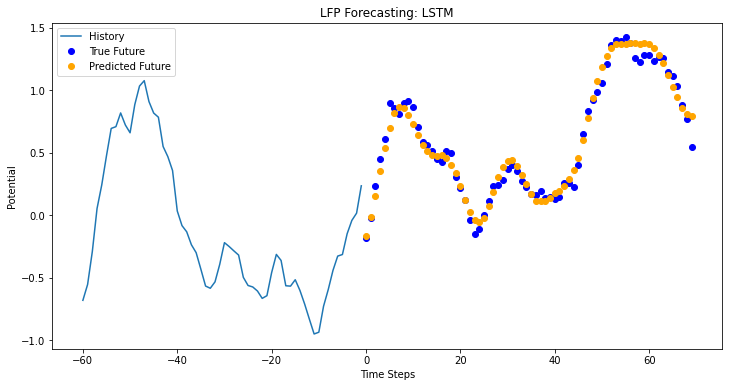

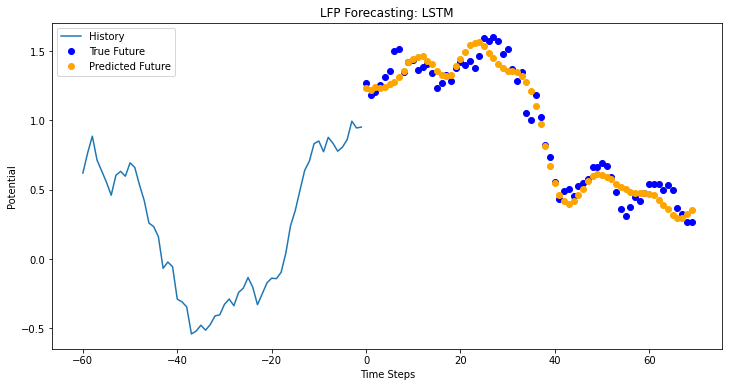

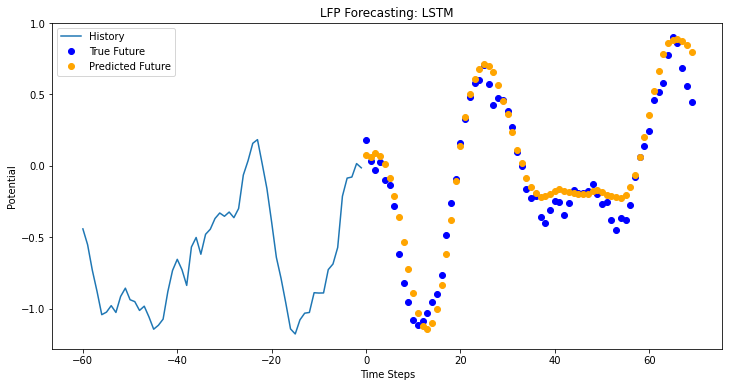

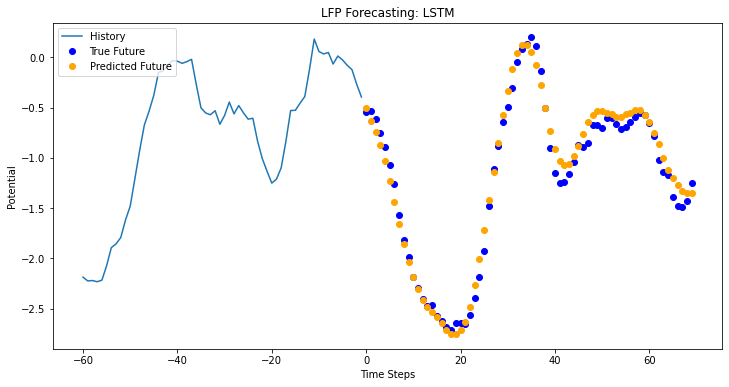

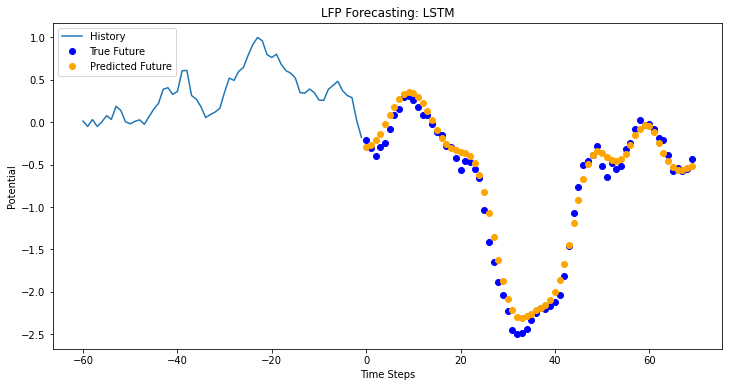

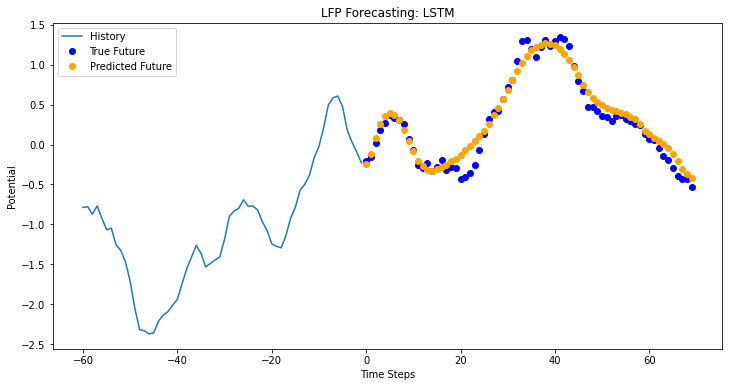

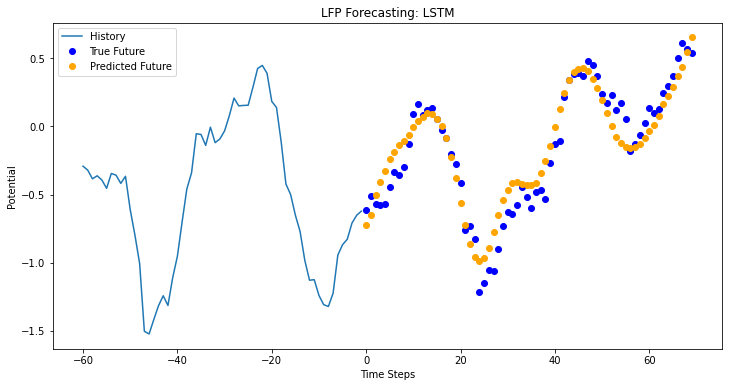

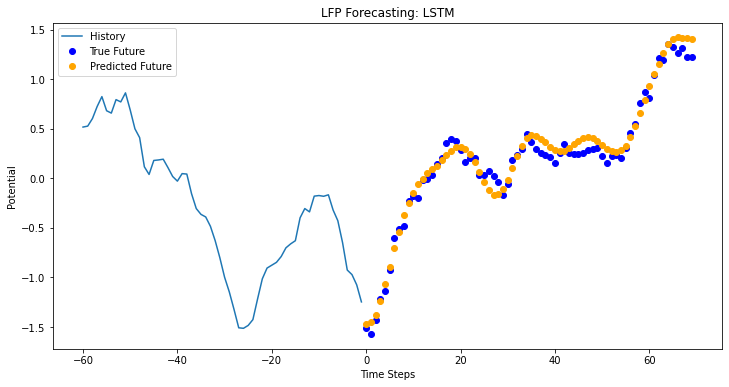

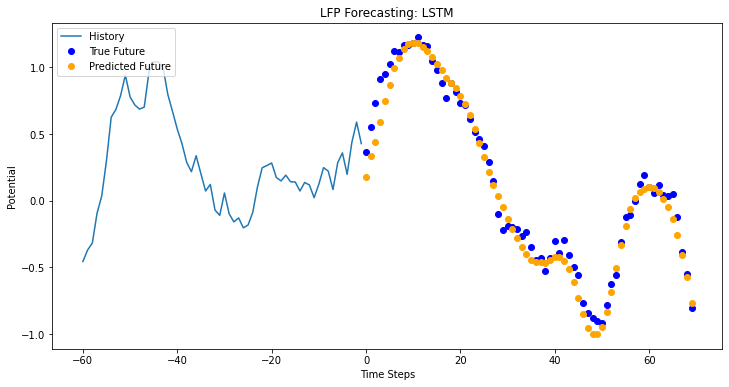

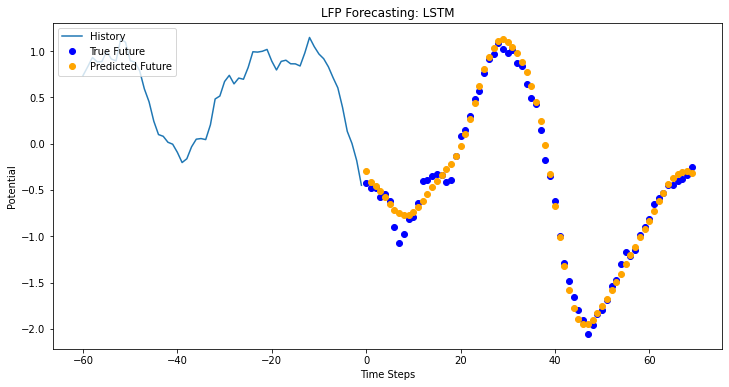

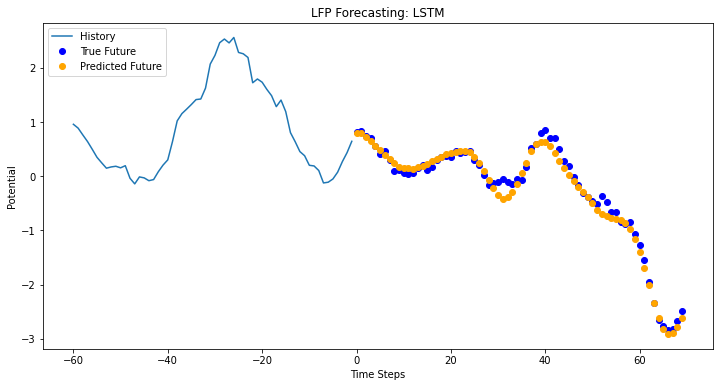

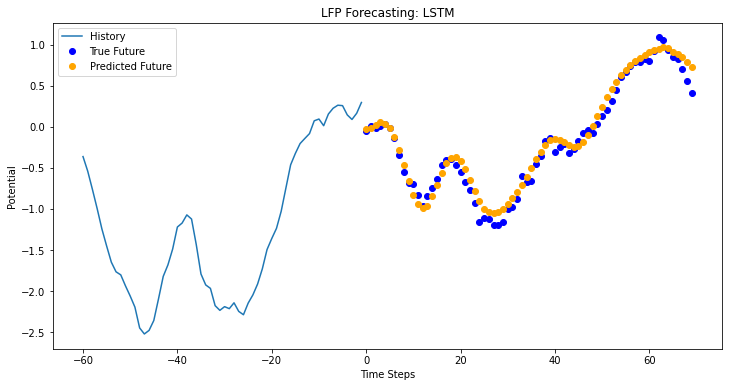

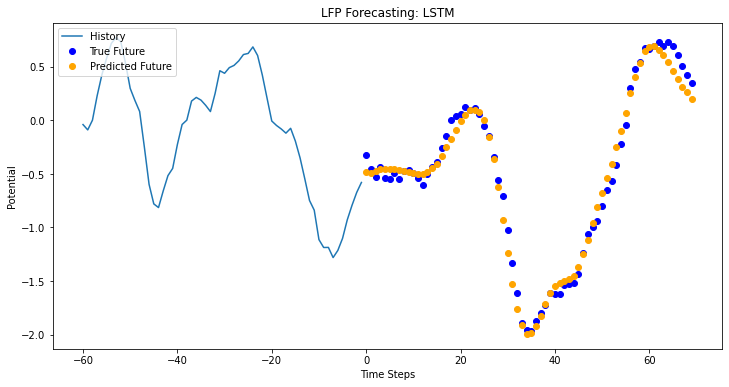

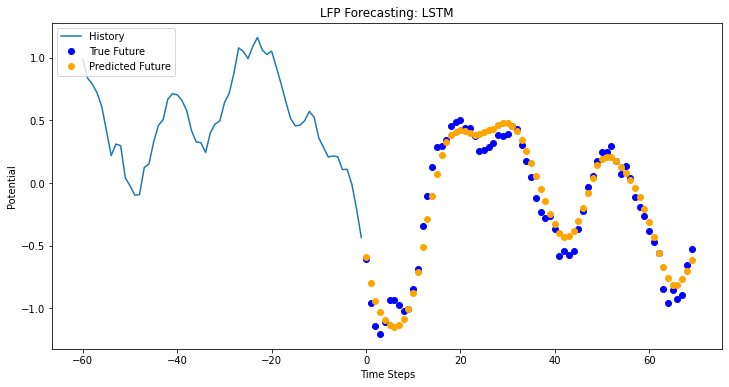

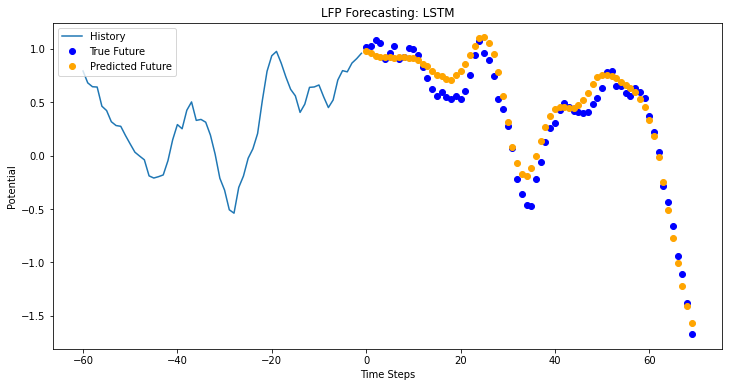

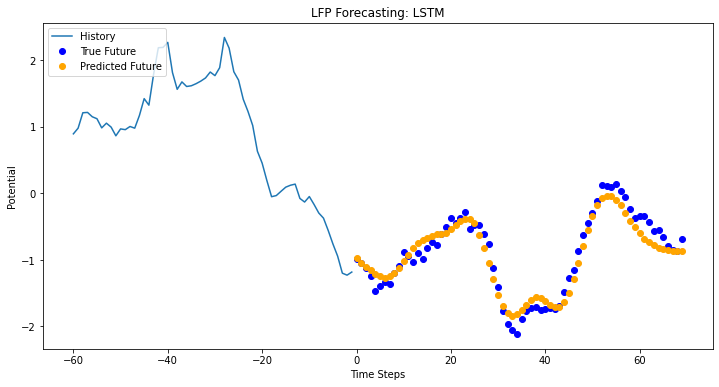

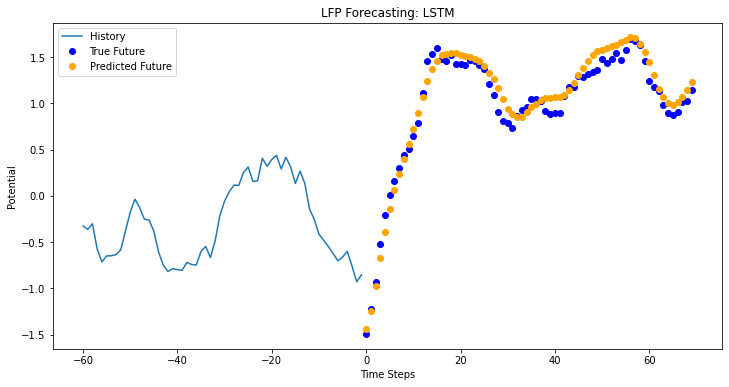

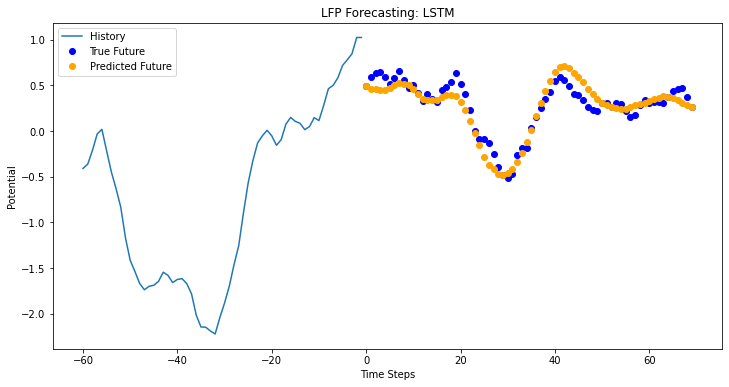

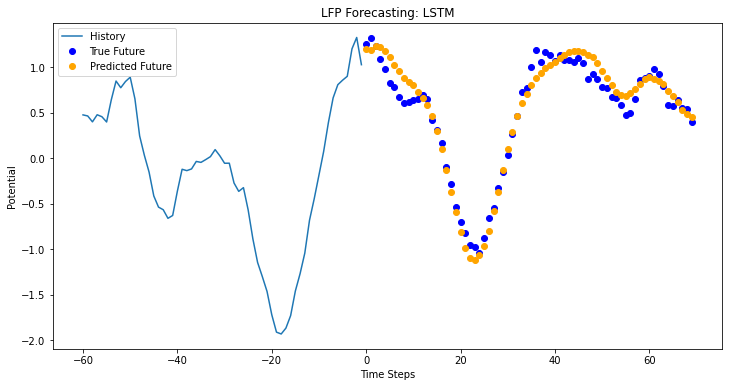

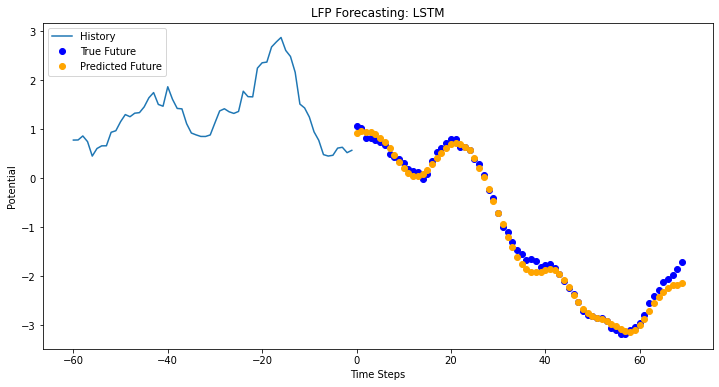

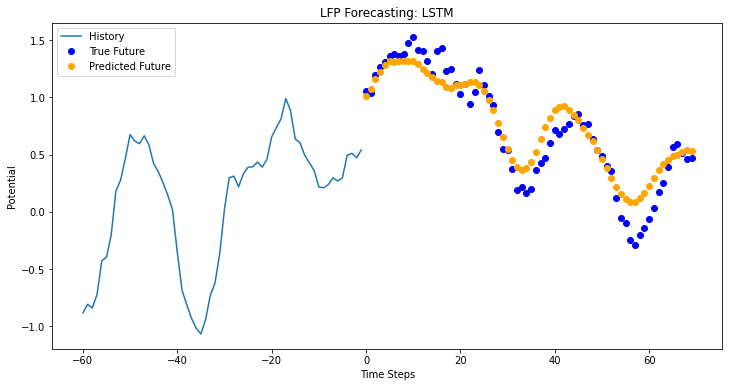

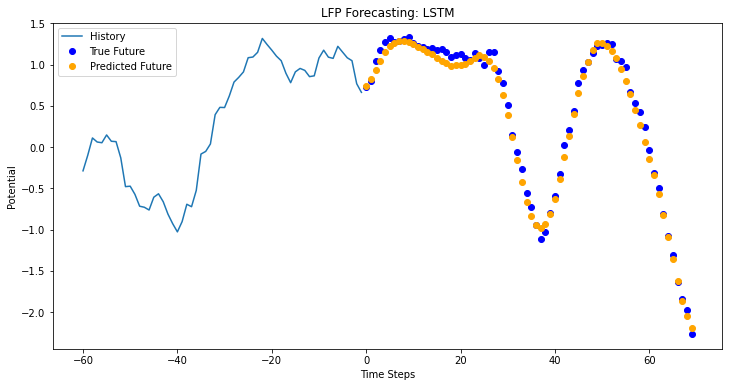

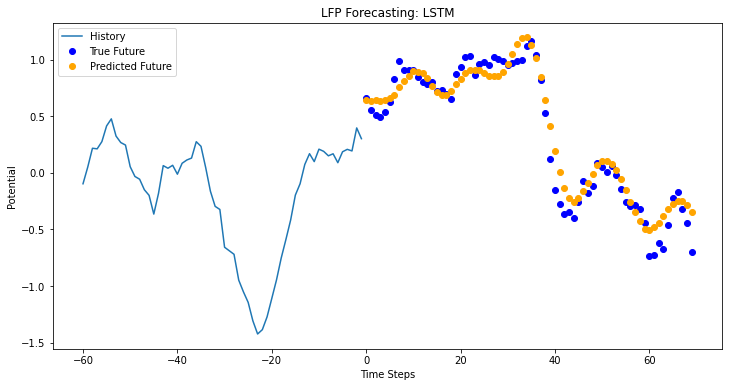

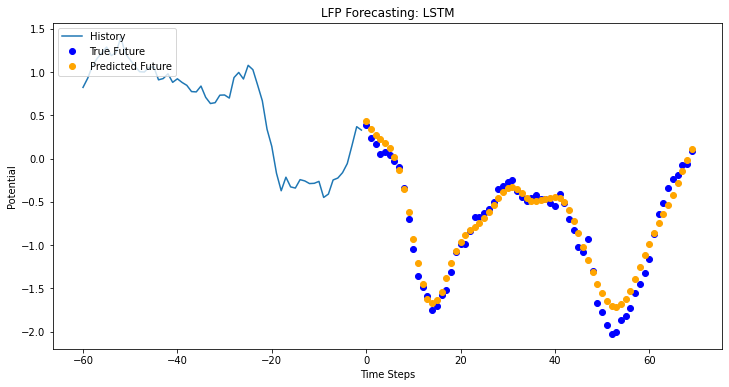

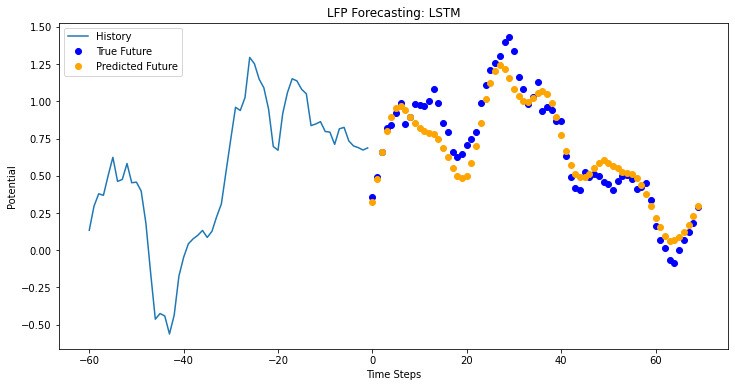

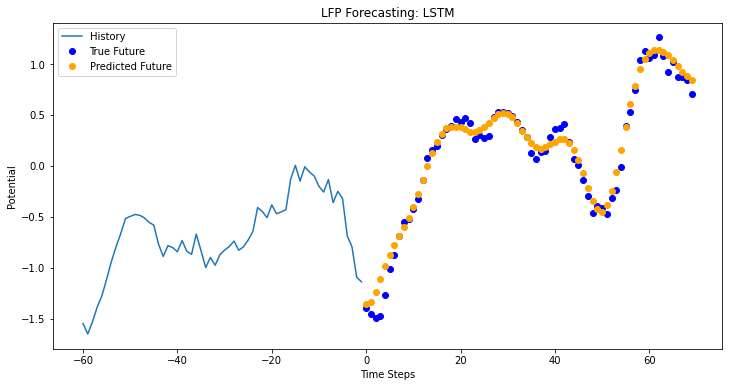

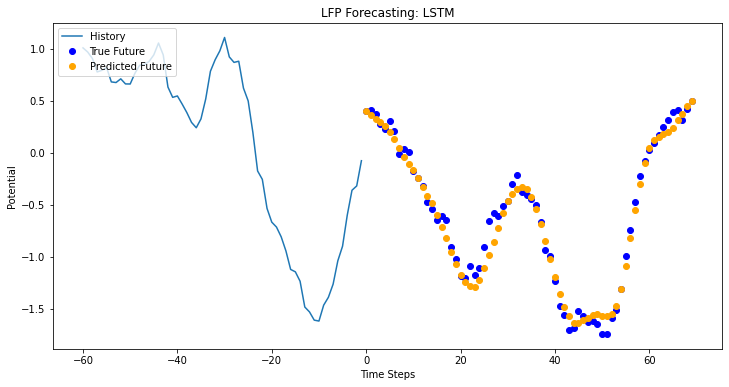

In [120]:
samples = 12
for x, y in val_data.take(30):
  results = lstm_model.predict(x)[0]
  multi_step_plot(x[0], y[0], results)

In [125]:
for x, y in val_data.take(1):
  start = time.perf_counter()
  results = lstm_model.predict(x)[0]
  end = time.perf_counter()
total = end - start
computing_time = total * 1000
print("Computing time: ", computing_time)

Computing time:  125.88352800230496


## Forecast Analysis

Open Best Results

In [0]:
best_results_file = open('./drive/My Drive/Colab Notebooks/best_results_iter1.pkl', 'rb')
best_results = pickle.load(best_results_file)
best_results_file.close()
best_results

{1: 0.0019,
 2: 0.0099,
 5: 0.0398,
 10: 0.1423,
 20: 0.4006,
 30: 0.3275,
 40: 0.5698,
 50: 0.6442,
 60: 0.7623,
 70: 0.8404,
 80: 0.8718,
 90: 0.7226,
 100: 0.7986}

#### Graph Errors vs Forecast Length

Text(0.5, 1.0, 'Forecast Length v Error')

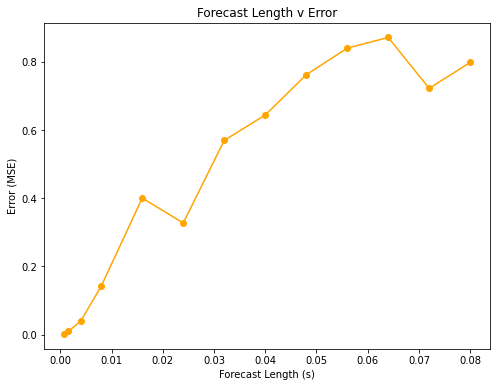

In [0]:
# Setup dict; after run, it will see if run is better, replace if so
time_steps =  np.array(list(best_results.keys()))
errors = np.array(list(best_results.values()))
time = time_steps * 0.0008 # Convert time step to seconds
plt.plot(time, errors, 'o-', color="orange")
plt.xlabel("Forecast Length (s)")
plt.ylabel("Error (MSE)")
plt.title("Forecast Length v Error")

## Different Model Comparison

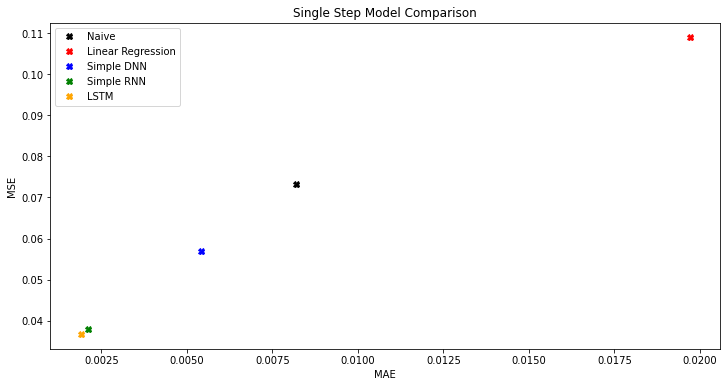

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(0.0082, 0.0732, 'kX', label='Naive')
plt.plot(0.0197, 0.1089, 'rX', label='Linear Regression')
plt.plot(0.0054, 0.0570, 'bX', label='Simple DNN')
plt.plot(0.0021, 0.0381, 'gX', label='Simple RNN')
plt.plot(0.0019, 0.0368, 'X', color="orange", label='LSTM')
plt.legend(loc='upper left')
plt.title("Single Step Model Comparison")
plt.ylabel("MSE")
plt.xlabel("MAE")
plt.show()

## Saving

### Save Model

In [0]:
# Save the weights, model
# model.save_weights('./checkpoints/lstm_32x32_fc_len_1_epochs_10') # Save weights
model.save('./drive/My Drive/Colab Notebooks/saved_models/drift_grat') # Save model

NameError: ignored

### Save Best Results

In [0]:
output = open('./drive/My Drive/Colab Notebooks/best_results.pkl', 'wb')
pickle.dump(best_results, output)
output.close()


## Functions

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def format_data(dataset, target, start_index, end_index, window_size,
                      forecast_length):
  data = []
  labels = []

  start_index = start_index + window_size
  if end_index is None:
    end_index = len(dataset) - forecast_length

  for i in range(start_index, end_index, 1):
    window_indices = range(i-window_size, i)
    data.append(dataset[window_indices])
    forecast_indices = range(i, i+forecast_length)
    labels.append(target[forecast_indices])     # Or append to target, if you don't want to try to predict all the data

  return np.array(data), np.array(labels)

In [0]:
# def format_data_encoder(dataset, target, start_index, end_index, window_size,
#                       forecast_length):
#   data = []
#   labels = []

#   start_index = start_index + window_size
#   if end_index is None:
#     end_index = len(dataset) - forecast_length

#   for i in range(start_index, end_index, 1):
#     indices = range(i-window_size, i)
#     data.append(dataset[indices])
#     labels.append(target[i:i+forecast_length])     # Or append to target, if you don't want to try to predict all the data
#   decoder_input = 

#   return np.array(data), np.array(labels)

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'o',color="orange",
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title("LFP Forecasting: LSTM")
  plt.ylabel("Potential")
  plt.xlabel("Time Steps")
  plt.show()

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)